In [1]:
%load_ext autoreload
%autoreload 2
import random
import yaml
import os
import logging
import matplotlib.pyplot as plt
import cv2

import scipy.io as io
import torch
import torch.optim
import torch.utils.data
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import open3d as o3d

from tensorboardX import SummaryWriter
from utils.utils import getWriterPath
from settings import EXPER_PATH
from utils.loader import dataLoader, modelLoader, pretrainedLoader
from utils.logging import *
from copy import deepcopy as dc
from utils.d2s import DepthToSpace, SpaceToDepth
from train_cubemap import *
from utils.utils import flattenDetection
from Train_model_frontend_cubemap import thd_img
from utils_custom import *
from PIL import Image
import matplotlib.pyplot as plt

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
def measure_t(start, before):
    now = time.time()
    runt = now-start
    h = runt//3600
    m = (runt - h*3600)//60
    s = round(runt - h*3600 - m*60)
    prtstr = f"iter {_iter+1} in {len(train_loader)}, \
            {round((_iter+1)/len(train_loader), 4) * 100}%\
            {h}h {m}m {s}s"
    runt2 = before-start
    h2 = runt2//3600
    m2 = (runt2 - h2*3600)//60
    s2 = round(runt2 - h2*3600 - m2*60)
    prtstr += f"  ({h2}h {m2}m {s2}s)"
    return now  
args = Namespace(command='train_joint', config='configs/magicpoint_cubemap.yaml', debug=False, eval=False, exper_name='cubemap_dataset', func=train_joint)


from utils_custom import *
from utils_custom_visualize import *

with open(args.config, 'r') as f:
    config = yaml.safe_load(f)
EXPER_PATH = 'logs'
output_dir = EXPER_PATH
output_dir

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'logs'

In [2]:
############################################### train_joint

torch.set_default_tensor_type(torch.FloatTensor)
task = config['data']['dataset']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info('train on device: %s', device)
with open(os.path.join(output_dir, 'config.yml'), 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
# writer = SummaryWriter(getWriterPath(task=args.command, date=True))
writer = SummaryWriter(getWriterPath(task=args.command, 
    exper_name=args.exper_name, date=True))
## save data
save_path = get_save_path(output_dir)

############################################### 
data = dataLoader(config, dataset=task, warp_input=True)
train_loader, val_loader = data['train_loader'], data['val_loader']

datasize(train_loader, config, tag='train')
datasize(val_loader, config, tag='val')
# init the training agent using config file
# from train_model_frontend import Train_model_frontend
from utils.loader import get_module
train_model_frontend = get_module('', config['front_end_model'])
train_agent = train_model_frontend(config, save_path=save_path, device=device)

# writer from tensorboard
train_agent.writer = writer

# feed the data into the agent
train_agent.train_loader = train_loader
train_agent.val_loader = val_loader

# load model initiates the model and load the pretrained model (if any)
train_agent.loadModel()

2023-04-11 17:37:16 koala-A520M-H root[1159313] INFO train on device: cuda
2023-04-11 17:37:16 koala-A520M-H root[1159313] INFO => will save everything to logs/checkpoints
2023-04-11 17:37:16 koala-A520M-H root[1159313] INFO workers_train: 1, workers_val: 1


dataset: CubemapDataset
not_warped_images:  False
not_warped_images:  False


2023-04-11 17:37:17 koala-A520M-H root[1159313] INFO == train split size 64800 in 64800 batches
2023-04-11 17:37:17 koala-A520M-H root[1159313] INFO == val split size 64800 in 64800 batches
2023-04-11 17:37:17 koala-A520M-H root[1159313] INFO => creating model: SuperPointNet_cubemap


Load Train_model_frontend!!
check config!! {'train_iter': 200000, 'save_interval': 2000, 'tensorboard_interval': 1000, 'model': {'subpixel': {'enable': False}, 'train_only_descriptor': True, 'name': 'SuperPointNet_cubemap', 'params': {}, 'detector_loss': {'loss_type': 'softmax'}, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'kernel_reg': 0.0, 'detection_threshold': 0.001, 'nms': 4, 'dense_loss': {'enable': False, 'params': {'descriptor_dist': 4, 'lambda_d': 800}}, 'sparse_loss': {'enable': True, 'params': {'num_matching_attempts': 1000, 'num_masked_non_matches_per_match': 100, 'lamda_d': 1, 'dist': 'cos', 'method': '2d'}}, 'other_settings': 'train 2d, gauss 0.5'}, 'data': {'dataset': 'CubemapDataset', 'primitives': 'all', 'not_warped_images': False, 'preprocessing': {'resize': [1024, 1024]}}, 'front_end_model': 'Train_model_frontend_cubemap', 'retrain': False, 'reset_iter': True, 'validation_interval': 1000, 'validation_size': 10, 'train_show_interval': 1000, 'seed': 

2023-04-11 17:37:17 koala-A520M-H root[1159313] INFO => setting adam solver
2023-04-11 17:37:17 koala-A520M-H root[1159313] INFO reset iterations to 0


adam optimizer
load pretrained model from: %s logs/magicpoint_synth_t2/checkpoints/3channel.pth.tar
successfully load pretrained model from: %s logs/magicpoint_synth_t2/checkpoints/3channel.pth.tar


 Train only descriptor


In [3]:
sample =next(iter(train_loader))
net = dc(train_agent.net)
print(sample.keys(), sample['image'].shape)
img, img_w = sample['image'].to(device), sample['warped_image'].to(device)
batch_size, H, W = img.shape[0], img.shape[2], img.shape[3]

dict_keys(['image', 'warped_image', 'ply_path', 'R', 'T', 'R_w', 'T_w', 'img_path', 'img_path_w', 'kpts2D', 'kpts3D', 'kpts2D_w', 'kpts3D_w']) torch.Size([1, 3, 1024, 1024])


In [4]:
sample.keys(), sample['image'].shape

(dict_keys(['image', 'warped_image', 'ply_path', 'R', 'T', 'R_w', 'T_w', 'img_path', 'img_path_w', 'kpts2D', 'kpts3D', 'kpts2D_w', 'kpts3D_w']),
 torch.Size([1, 3, 1024, 1024]))

In [5]:
thd = 0.05
B, h, b, loss = 0, 0, 0, 0

dbk2d, dbk2d_w, dbk3d, dbk3d_w = sample['kpts2D'][B],sample['kpts2D_w'][B],sample['kpts3D'][B],sample['kpts3D_w'][B]        

H_NUM_THIS = 2

im_trf_cat, Hinv_infos = get_homo_img_cat(img, H_NUM_THIS)
im_trf_cat_w, Hinv_infos_w = get_homo_img_cat(img_w, H_NUM_THIS)

outs, outs_warp = (
    net(im_trf_cat[B]),  # B는 배치를 뜻함, 배치는 1로 고정, (b, bh, c, H, W)
    net(im_trf_cat_w[B]),# 모델 인풋은 4차원이어야 하므로 bh를 b처럼 이용
    )
semi, coarse_desc = outs['semi'], outs['desc']
hms = flattenDetection(semi)
semi_w, coarse_desc_w = outs_warp['semi'], outs_warp['desc']
hms_w = flattenDetection(semi_w)

desc = train_agent.interpolate_to_dense(coarse_desc)
desc_w = train_agent.interpolate_to_dense(coarse_desc_w)

In [7]:
from utils.loss_functions.custom_loss import *

imgshape = (H_NUM_THIS, H, W)
labels3D_in_loss = getLabels(imgshape, dbk2d, device=device)
labels3D_in_loss_w = getLabels(imgshape, dbk2d, device=device)

bh = 0
n_iter = 1  ##########

from copy import deepcopy as dc
############################################################################
mask_3D_flattened, mask2D = getMasks(imgshape, dc(Hinv_infos[bh]), device=device)
loss_det = detection_loss_custom(
    semi[bh], labels3D_in_loss[bh], mask_3D_flattened, device=device
)

mask_3D_flattened_w, mask2D_w = getMasks(imgshape, dc(Hinv_infos_w[bh]), device=device)
loss_det_w = detection_loss_custom(
    semi_w[bh], labels3D_in_loss_w[bh], mask_3D_flattened_w, device=device
)
############################################################################

hm = apply_H_from_info(hms[bh], Hinv_infos[bh])
hm = thd_img(hm, thd=thd)
kpts = get_kpts_from_hm(hm, mask2D)

hm_w = apply_H_from_info(hms_w[bh], Hinv_infos_w[bh])
hm_w = thd_img(hm_w, thd=thd)
kpts_w = get_kpts_from_hm(hm_w, mask2D_w)

/home/koala/anaconda3/envs/pnp/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [8]:
kpts_desc = get_desc_of_kpts(desc[b], kpts)
kpts_desc_w = get_desc_of_kpts(desc_w[b], kpts_w)
kpts_desc = kpts_desc.transpose(0, 1)
kpts_desc_w = kpts_desc_w.transpose(0, 1)

In [9]:
len(kpts), kpts_desc.shape, len(kpts_w), kpts_desc_w.shape

(2242, torch.Size([2242, 256]), 3204, torch.Size([3204, 256]))

In [40]:
kpts = torch.Tensor(kpts).to(device)
kpts_w = torch.Tensor(kpts_w).to(device)

kpts_sorted, kpts_w_sorted, color = sort_by_similar_pts(kpts, kpts_w, kpts_desc, kpts_desc_w)
kpts_w_sorted.shape,color

(torch.Size([109, 2]),
 [[0, 78, 78],
  [0, 45, 45],
  [0, 56, 56],
  [0, 76, 76],
  [0, 76, 76],
  [0, 79, 79],
  [0, 55, 55],
  [0, 49, 49],
  [0, 60, 60],
  [0, 39, 39],
  [0, 43, 43],
  [0, 144, 144],
  [0, 55, 55],
  [0, 70, 70],
  [0, 68, 68],
  [0, 47, 47],
  [0, 85, 85],
  [0, 51, 51],
  [0, 48, 48],
  [0, 60, 60],
  [0, 129, 129],
  [0, 34, 34],
  [0, 52, 52],
  [0, 22, 22],
  [0, 137, 137],
  [0, 197, 197],
  [0, 210, 210],
  [0, 45, 45],
  [0, 173, 173],
  [0, 188, 188],
  [0, 212, 212],
  [0, 210, 210],
  [0, 210, 210],
  [0, 50, 50],
  [0, 209, 209],
  [0, 56, 56],
  [0, 52, 52],
  [0, 49, 49],
  [0, 86, 86],
  [0, 196, 196],
  [0, 36, 36],
  [0, 73, 73],
  [0, 49, 49],
  [0, 106, 106],
  [0, 60, 60],
  [0, 84, 84],
  [0, 135, 135],
  [0, 49, 49],
  [0, 102, 102],
  [0, 87, 87],
  [0, 135, 135],
  [0, 45, 45],
  [0, 50, 50],
  [0, 47, 47],
  [0, 94, 94],
  [0, 42, 42],
  [0, 84, 84],
  [0, 93, 93],
  [0, 61, 61],
  [0, 65, 65],
  [0, 58, 58],
  [0, 85, 85],
  [0, 61, 61],


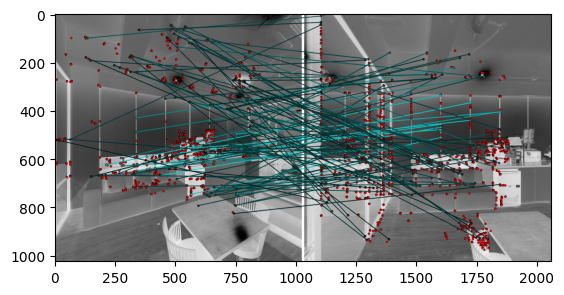

In [41]:
from utils_custom_visualize import *
outfig = maching_plot(sample['img_path'][0], sample['img_path_w'][0], 
        kpts.detach().cpu(), kpts_w.detach().cpu(), 
        kpts_sorted.detach().cpu(), kpts_w_sorted.detach().cpu(), color,
                                 img_shape=img.shape[2:])
plt.imshow(outfig)
plt.savefig('rd_glue2.jpg', dpi=1200)